In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Mounted at /content/drive


In [3]:
num_samples = 1000
sample_range = range(0, 200)

Sparse Bayesian Learning (SBL)

In [4]:
def sbl_algorithm(theta, y, noise_var, max_iter=500, stopping_criterion=1e-4):
    # Sparse Bayesian Learning (SBL) for Multiple Measurement Vectors (MMV).

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess: identity matrix

    # Iterative update process
    for t in range(max_iter):
       # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute gamma update using the derived formula
        gamma_new = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))

        # Ensure non-negativity for numerical stability
        gamma_new = np.maximum(gamma_new, 1e-8)

        # Check for convergence: if change is below threshold, stop iterations
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma with new values
        Gamma = np.diagflat(gamma_new)

    # Return final estimates
    return mu_x, np.diag(Gamma)


In [5]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(snr_db_array)))         # HR
fr_res = np.zeros((num_samples, len(snr_db_array)))         # FR
srr_res = np.zeros((num_samples, len(snr_db_array)))        # SRR
precision_res = np.zeros((num_samples, len(snr_db_array)))  # Precision
recall_res = np.zeros((num_samples, len(snr_db_array)))     # Recall
f1_res = np.zeros((num_samples, len(snr_db_array)))         # F1
nmse_res = np.zeros((num_samples, len(snr_db_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = sbl_algorithm(theta, received_signal, noise_power)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool = gamma_result > 0.05
        gamma_res[sample_index, snr_db_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, snr_db_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, snr_db_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, snr_db_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index]) > 0:
            f1_res[sample_index, snr_db_index] = (
                2 * precision_res[sample_index, snr_db_index] * recall_res[sample_index, snr_db_index]
                /
                (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index])
            )
        else:
            f1_res[sample_index, snr_db_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, snr_db_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Samples:   2%|▏         | 3/200 [04:43<5:10:13, 94.49s/it]

Converged after 402 iterations



Processing Samples:   2%|▏         | 4/200 [06:16<5:07:11, 94.04s/it]

Converged after 482 iterations



Processing Samples:   3%|▎         | 6/200 [09:30<5:08:03, 95.27s/it]

Converged after 376 iterations



Processing Samples:   8%|▊         | 16/200 [25:32<4:51:54, 95.19s/it]

Converged after 371 iterations



Processing Samples:  10%|█         | 21/200 [33:26<4:40:42, 94.09s/it]

Converged after 345 iterations



Processing Samples:  12%|█▎        | 25/200 [39:52<4:39:36, 95.86s/it]

Converged after 484 iterations



Processing Samples:  14%|█▍        | 28/200 [44:38<4:33:45, 95.50s/it]

Converged after 499 iterations



Processing Samples:  14%|█▍        | 29/200 [46:16<4:34:05, 96.17s/it]

Converged after 495 iterations



Processing Samples:  16%|█▌        | 32/200 [51:03<4:27:51, 95.67s/it]

Converged after 450 iterations



Processing Samples:  18%|█▊        | 36/200 [57:24<4:20:45, 95.40s/it]

Converged after 418 iterations



Processing Samples:  19%|█▉        | 38/200 [1:00:38<4:19:51, 96.24s/it]

Converged after 489 iterations



Processing Samples:  20%|█▉        | 39/200 [1:02:16<4:20:06, 96.93s/it]

Converged after 496 iterations



Processing Samples:  20%|██        | 40/200 [1:03:51<4:16:49, 96.31s/it]

Converged after 489 iterations



Processing Samples:  22%|██▏       | 43/200 [1:08:38<4:09:47, 95.46s/it]

Converged after 432 iterations



Processing Samples:  25%|██▌       | 50/200 [1:19:48<3:58:24, 95.36s/it]

Converged after 394 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.95s/it]

Converged after 494 iterations



Processing Samples:  30%|███       | 60/200 [1:36:08<3:49:40, 98.44s/it]

Converged after 420 iterations



Processing Samples:  34%|███▍      | 69/200 [1:50:48<3:34:44, 98.35s/it]

Converged after 462 iterations



Processing Samples:  38%|███▊      | 75/200 [2:00:36<3:23:56, 97.89s/it]

Converged after 467 iterations



Processing Samples:  38%|███▊      | 77/200 [2:03:50<3:19:10, 97.16s/it]

Converged after 388 iterations



Processing Samples:  39%|███▉      | 78/200 [2:05:28<3:18:21, 97.56s/it]

Converged after 458 iterations



Processing Samples:  40%|███▉      | 79/200 [2:07:02<3:14:50, 96.62s/it]

Converged after 431 iterations



Processing Samples:  40%|████      | 80/200 [2:08:41<3:14:27, 97.23s/it]

Converged after 499 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.46s/it]

Converged after 458 iterations



Processing Samples:  49%|████▉     | 98/200 [2:38:09<2:46:29, 97.94s/it]

Converged after 478 iterations



Processing Samples:  50%|█████     | 100/200 [2:41:24<2:42:13, 97.34s/it]

Converged after 467 iterations



Processing Samples:  60%|██████    | 120/200 [3:14:17<2:10:53, 98.16s/it]

Converged after 485 iterations



Processing Samples:  64%|██████▍   | 129/200 [3:28:58<1:55:59, 98.01s/it]

Converged after 498 iterations



Processing Samples:  66%|██████▌   | 132/200 [3:33:50<1:49:57, 97.02s/it]

Converged after 422 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.90s/it]

Converged after 491 iterations



Processing Samples:  72%|███████▏  | 143/200 [3:51:40<1:31:59, 96.83s/it]

Converged after 489 iterations



Processing Samples:  72%|███████▏  | 144/200 [3:53:18<1:30:45, 97.24s/it]

Converged after 496 iterations



Processing Samples:  73%|███████▎  | 146/200 [3:56:31<1:26:56, 96.60s/it]

Converged after 482 iterations



Processing Samples:  74%|███████▎  | 147/200 [3:58:08<1:25:29, 96.79s/it]

Converged after 458 iterations



Processing Samples:  77%|███████▋  | 154/200 [4:09:23<1:13:46, 96.22s/it]

Converged after 422 iterations



Processing Samples:  79%|███████▉  | 158/200 [4:15:45<1:06:32, 95.05s/it]

Converged after 360 iterations



Processing Samples:  80%|███████▉  | 159/200 [4:17:21<1:05:10, 95.39s/it]

Converged after 458 iterations



Processing Samples:  83%|████████▎ | 166/200 [4:28:36<54:43, 96.59s/it]

Converged after 472 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.25s/it]

Converged after 431 iterations



Processing Samples:  85%|████████▌ | 170/200 [4:35:02<48:16, 96.54s/it]

Converged after 456 iterations



Processing Samples:  90%|█████████ | 180/200 [4:51:33<33:10, 99.52s/it]

Converged after 460 iterations



Processing Samples:  94%|█████████▎| 187/200 [5:03:04<21:12, 97.87s/it]

Converged after 445 iterations



Processing Samples:  96%|█████████▋| 193/200 [5:13:39<11:36, 99.50s/it] 

Converged after 398 iterations



Processing Samples:  98%|█████████▊| 195/200 [5:16:55<08:12, 98.50s/it]

Converged after 368 iterations



Processing Samples: 100%|██████████| 200/200 [5:25:04<00:00, 97.52s/it]


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [11.38  14.78  18.13  19.705 19.98  19.995]
Avg SRR : [0.04748439 0.07492332 0.12287425 0.18066869 0.19908333 0.19979167]
Avg FR  : [1.07921053e+00 8.10526316e-01 4.52368421e-01 9.39473684e-02
 3.68421053e-03 7.89473684e-04]
Avg PR  : [0.07188881 0.09874045 0.13734351 0.18427079 0.19934416 0.19986364]
Avg RE  : [0.1138  0.1478  0.1813  0.19705 0.1998  0.19995]
Avg F1  : [0.0879185  0.11814387 0.15591072 0.19026525 0.19956437 0.19990476]
Avg NMSE: [0.12766193 0.08777375 0.04558575 0.01508165 0.00478021 0.00185737]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-sbl-snr-db-all-pilot-length-30-set-1.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length=pilot_length,
    snr_db_array=snr_db_array
)

print("All results have been saved")

All results have been saved


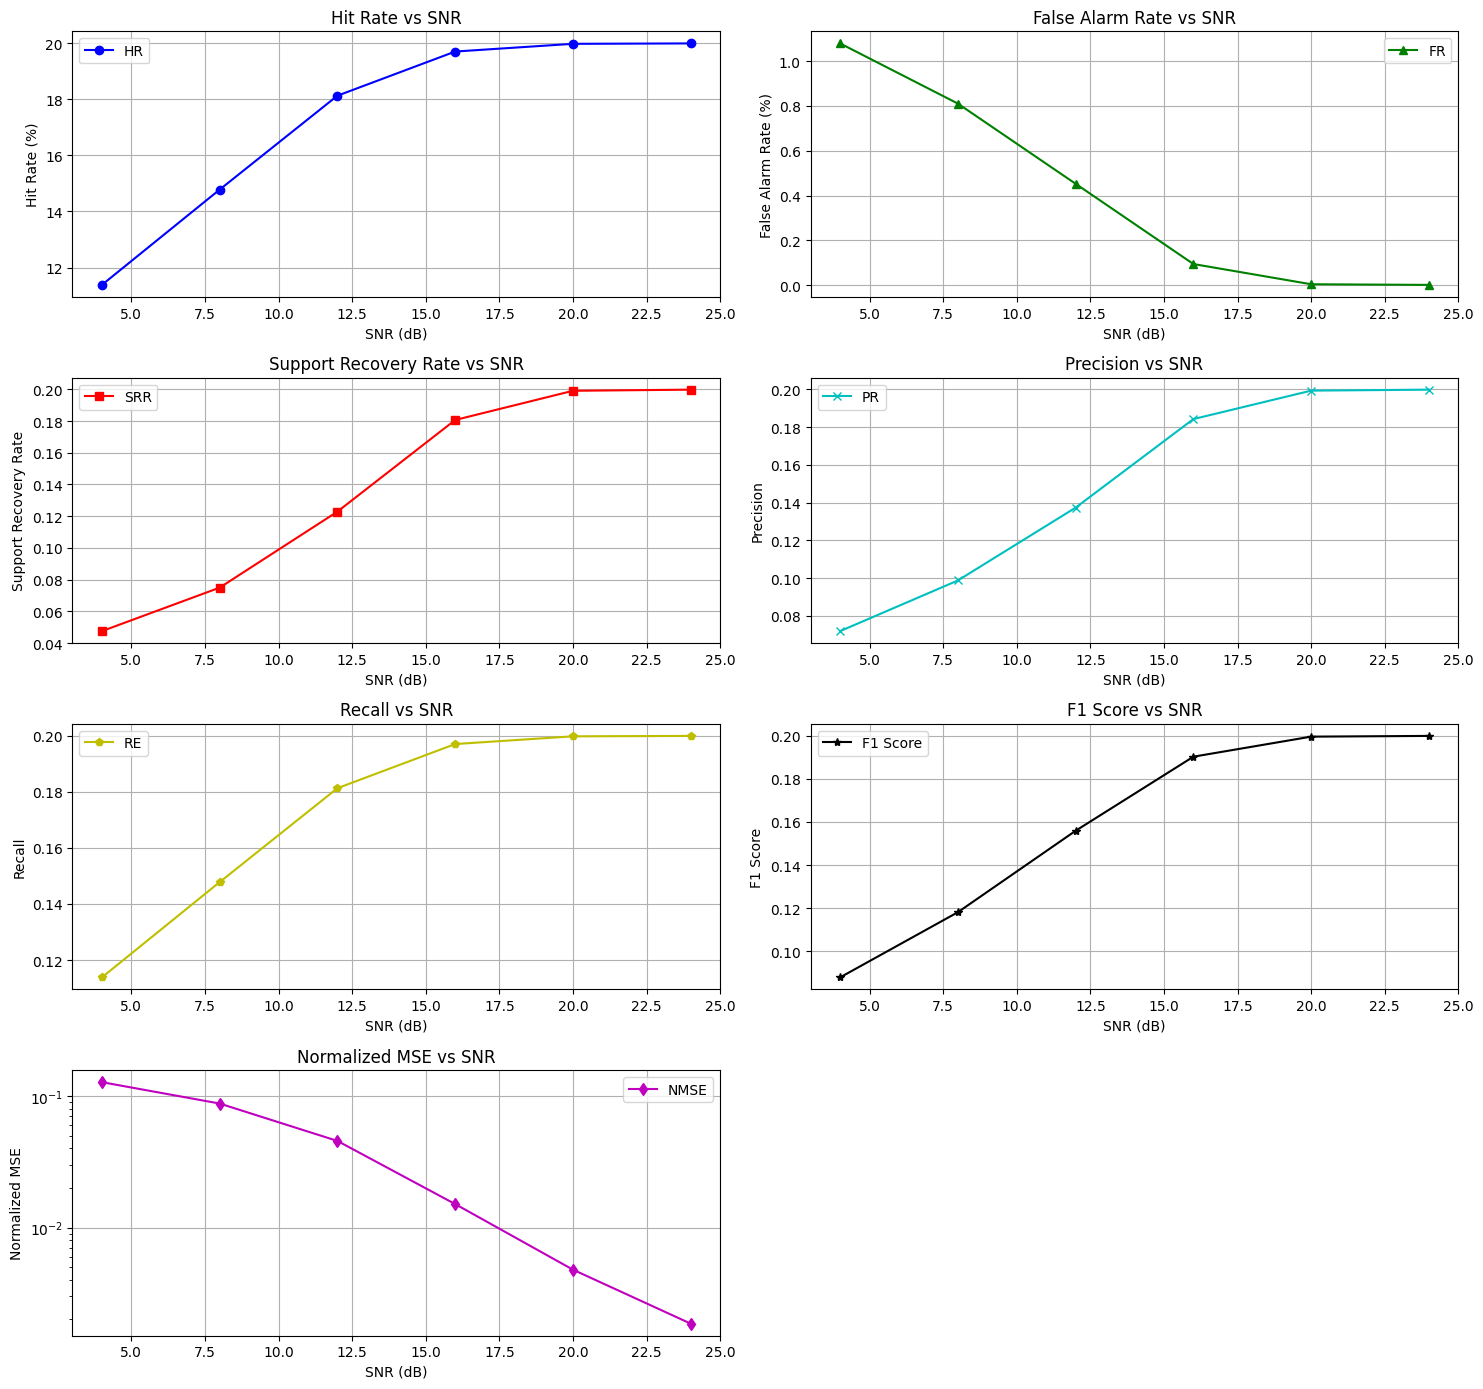

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(snr_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(snr_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(snr_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("SNR (dB)")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(snr_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("SNR (dB)")
plt.ylabel("Precision")
plt.title("Precision vs SNR")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(snr_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("SNR (dB)")
plt.ylabel("Recall")
plt.title("Recall vs SNR")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(snr_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("SNR (dB)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(snr_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

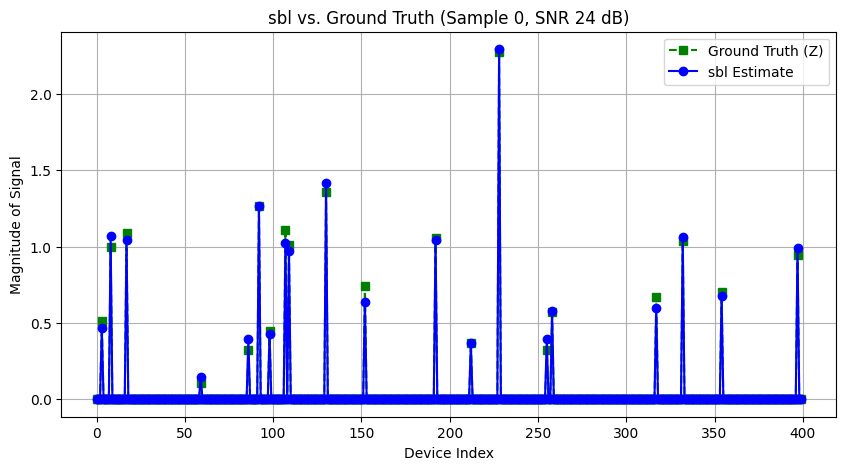

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


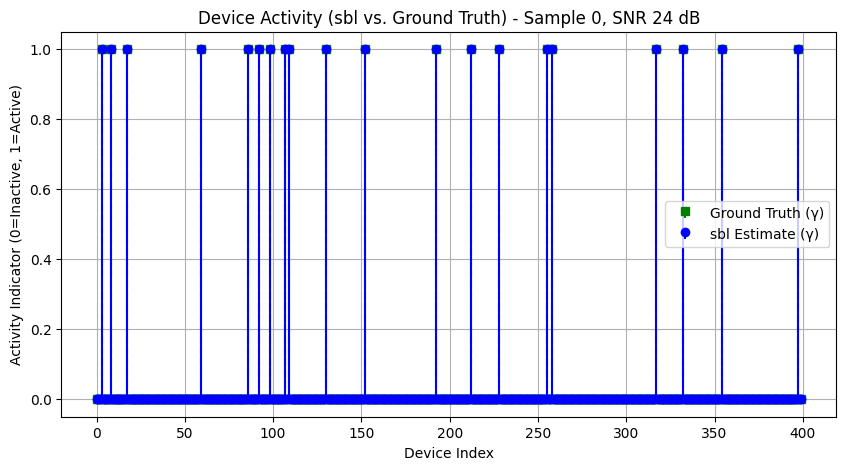

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)